In [37]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Union
import multiprocessing as mp
from functools import partial

import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from autoencoder_keras import AutoEncoder
import resources

In [2]:
HOME_DIR, BASE_DIR, CODE_DIR, TB_DIR, RMS_DATA_DIR = resources.config_paths()

In [3]:
# Setup Tensorflow
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print('Num GPUs Available: ', len(gpus))
    try:
        # Limit memory usage to 5GB of the first GPU (if available)
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]
        )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)
else:
    print('No GPUs Available')

# tf.config.set_visible_devices([], 'GPU')

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [64]:
exp = 'Test 5'
exp_data = resources.load(exp)
exp_data

Test No: 5
Date: 2022-08-03
Data: ../../Testing/22_08_03_grit1000
No. Files: AE-214 NC4-214

In [65]:
FFT_RES = 1000

# Check if exp has fft data
if FFT_RES in exp_data.ae.fft.keys():
    ffts = pd.DataFrame(exp_data.ae.fft[1000])
else:
    ffts = np.zeros((len(exp_data.ae._files), int(1e6/FFT_RES)))
    for i in range(len(exp_data.ae._files)):
        ffts[i, :] = exp_data.ae._fftcalc(i, FFT_RES)
    ffts = exp_data.ae.volt2db(np.array(ffts))
    ffts = pd.DataFrame(ffts)
ffts.drop([0, 1, 2], axis=0, inplace=True)
ffts.shape

(211, 1000)

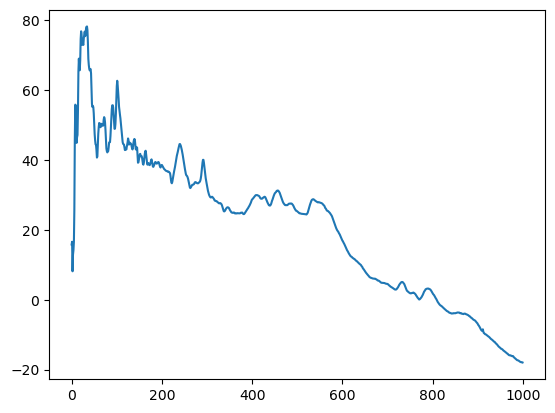

In [66]:
plt.plot(ffts.iloc[11, :])

In [67]:
def pre_process(data: np.array, ind: (tuple, tuple)):
    ind_tr, ind_val = ind

    ind_tr, ind_te = train_test_split(ind_tr,
                                      test_size=0.2,
                                      random_state=42,
                                      )
    scaler = MinMaxScaler()
    scaler.fit(data[ind_tr, :].reshape(-1, 1))
    data_sc = scaler.transform(data.reshape(-1, 1)).reshape(data.shape)

    x_train = data_sc[ind_tr, :]
    x_val = data_sc[ind_val, :]
    x_test = data_sc[ind_te, :]
    return x_train, x_test, x_val, data_sc

In [68]:
TRAIN_STOP = 10

x_train, x_test, x_val, data_sc = pre_process(ffts.values,
                                              (range(TRAIN_STOP),
                                               range(TRAIN_STOP, ffts.shape[0])
                                               ),
                                              )

In [69]:
autoe = AutoEncoder(x_train.shape[1],
                    latent_dim=64,
                    n_size=[256, 128],
                    dropout=0.01,
                    )
autoe.build_graph().summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1000)]            0         
                                                                 
 encoder (Functional)        (None, 64)                297408    
                                                                 
 decoder (Functional)        (None, 1000)              298344    
                                                                 
Total params: 595,752
Trainable params: 595,752
Non-trainable params: 0
_________________________________________________________________


In [70]:
autoe.compile(optimizer=keras.optimizers.Adam(),)

In [71]:
history = autoe.fit(x_train, x_train,
                    validation_data=(x_test, x_test),
                    epochs=300,
                    batch_size=32,
                    )

Epoch 1/300


1/1 [==============================] - 1s 522ms/step - loss: 0.2181 - val_loss: 0.2069
Epoch 2/300
1/1 [==============================] - 0s 66ms/step - loss: 0.2071 - val_loss: 0.1839
Epoch 3/300
1/1 [==============================] - 0s 39ms/step - loss: 0.1840 - val_loss: 0.1525
Epoch 4/300
1/1 [==============================] - 0s 44ms/step - loss: 0.1536 - val_loss: 0.1218
Epoch 5/300
1/1 [==============================] - 0s 48ms/step - loss: 0.1233 - val_loss: 0.0963
Epoch 6/300
1/1 [==============================] - 0s 46ms/step - loss: 0.0979 - val_loss: 0.0700
Epoch 7/300
1/1 [==============================] - 0s 55ms/step - loss: 0.0715 - val_loss: 0.0480
Epoch 8/300
1/1 [==============================] - 0s 37ms/step - loss: 0.0494 - val_loss: 0.0347
Epoch 9/300
1/1 [==============================] - 0s 40ms/step - loss: 0.0367 - val_loss: 0.0241
Epoch 10/300
1/1 [==============================] - 0s 45ms/step - loss: 0.0255 - val_loss: 0.0179
Epoch 11/300
1/1 [============

Text(0.5, 0, 'Epoch')

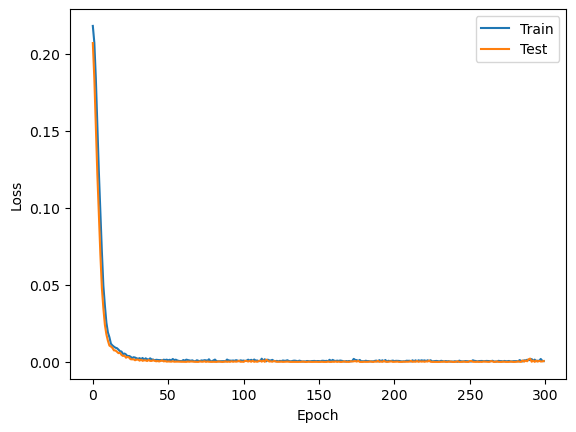

In [72]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Train')
ax.plot(history.history['val_loss'], label='Test')
ax.legend()
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')

In [73]:
predictions = autoe.predict(data_sc)

recon_scores = mean_squared_error(data_sc.T, predictions.T, multioutput='raw_values')

7/7 [==============================] - 0s 3ms/step


In [74]:
def pred_plot(i: Union[int, list], input, pred):
    fig, ax = plt.subplots(1, len(i), constrained_layout=True, figsize=(15, 5))
    try:
        ax = ax.ravel()
    except AttributeError:
        ax = [ax]

    for ind in range(len(i)):
        ax[ind].plot(input[i[ind], :], label='Original')
        ax[ind].plot(pred[i[ind], :], label='Reconstructed')
        ax[ind].set_ylabel('Normalised PSD')
        ax[ind].set_xlabel('Freqency Bin')
        ax[ind].set_title(f'AUTOE Reconstruction of PSD {i[ind]}')
    lines, labels = ax[0].get_legend_handles_labels()
    fig.legend(lines, labels, loc='upper left', bbox_to_anchor=(1, 1))

    return fig, ax

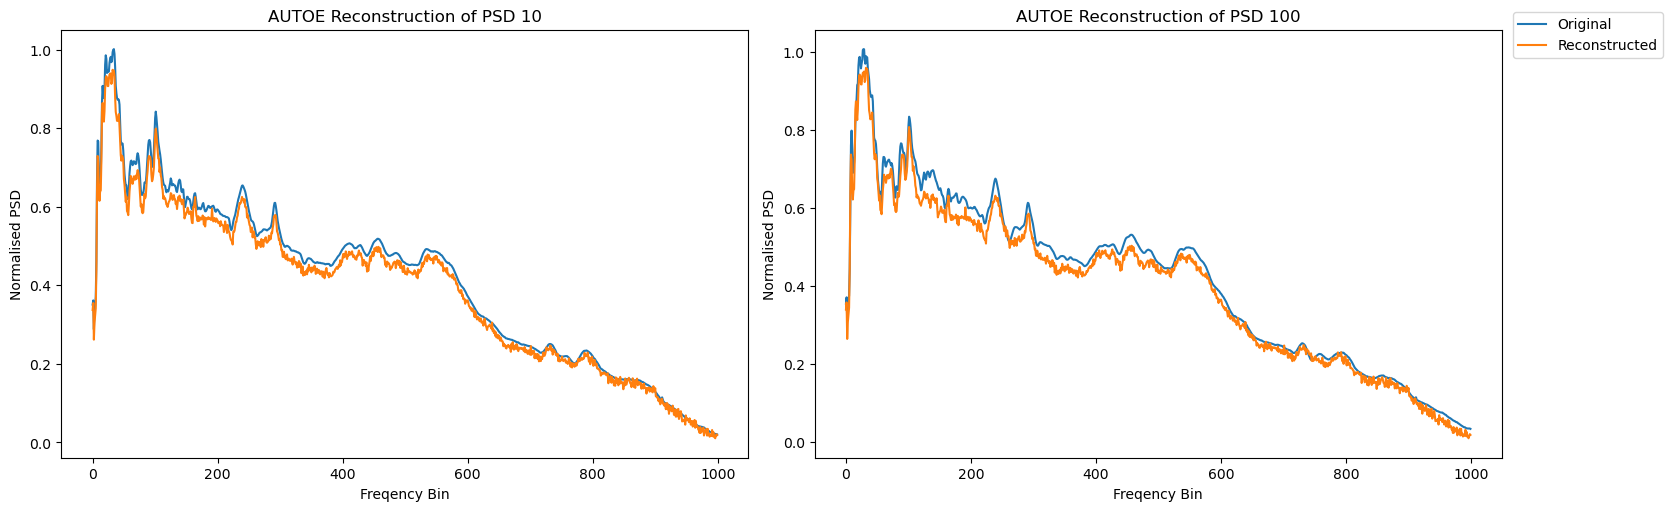

In [75]:
i = [10, 100]
pred_plot(i, data_sc, predictions)
plt.show()

In [76]:
def reject_outliers(data, m = 10):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]

In [77]:
def fit_poly(x, y, deg=None):
    if deg is None:
        deg = [1, 2, 3, 4, 5]
    else:
        deg = [deg]

    # find best degree based on MSE
    mse = 1
    for d in deg:
        cf = np.polyfit(x, y, d)
        p = np.polyval(cf, x)
        m = mean_squared_error(y, p)
        if m < mse:
            cf_out = cf
            mse = m
    return cf_out

In [82]:
y = recon_scores
# remove outliers
y = reject_outliers(recon_scores)

x = np.arange(len(y))

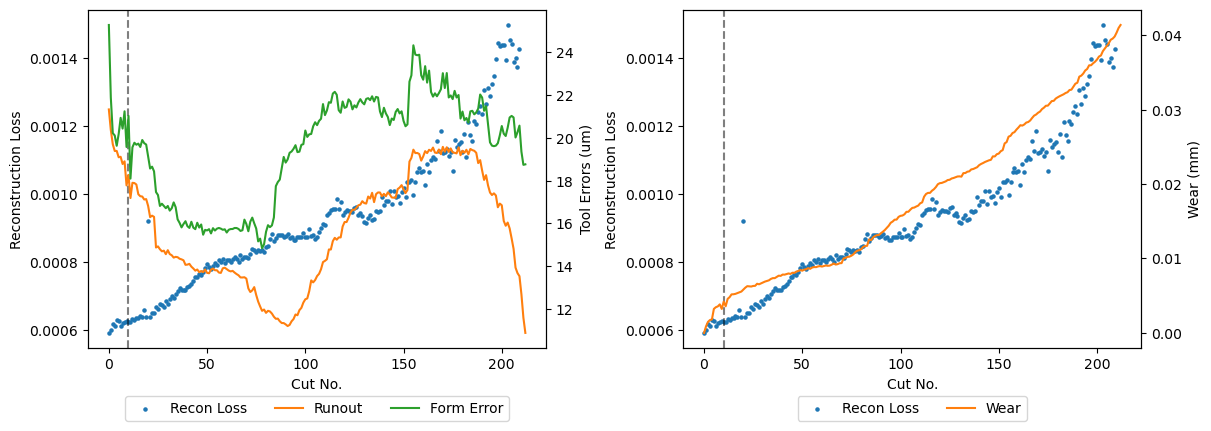

In [83]:
runout = exp_data.features['Runout'] * 1000
form_error = exp_data.features['Form error'] * 1000
mean_rad = exp_data.features['Mean radius']
wear = np.abs(mean_rad - mean_rad.iloc[0])

# line of best fit
cf  = fit_poly(x, y, 1)
lbf = np.polyval(cf, x)


fig, ax = plt.subplots(1, 2, figsize=(12, 4.2), constrained_layout=True)
ax[0].scatter(x,
              y,
              s=5,
              label='Recon Loss',
              )
# ax[0].plot(lbf, 'k--', alpha=0.5)
ax[0].axvline(TRAIN_STOP,
            color='k',
            linestyle='--',
            alpha=0.5,
            )
ax2 = ax[0].twinx()
ax2.plot(runout, 'C1', label='Runout')
ax2.plot(form_error, 'C2', label='Form Error')

ax[0].set_ylabel('Reconstruction Loss')
ax2.set_ylabel('Tool Errors (um)')
ax[0].set_xlabel('Cut No.')

lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax[0].legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=len(lines+lines2))

# wear plot
ax[1].scatter(x,
              y,
              s=5,
              label='Recon Loss',
              )
# ax[1].plot(lbf, 'k--', alpha=0.5)
ax[1].axvline(TRAIN_STOP,
            color='k',
            linestyle='--',
            alpha=0.5,
            )
ax3= ax[1].twinx()
ax3.plot(wear, 'C1', label='Wear')

ax[1].set_ylabel('Reconstruction Loss')
ax3.set_ylabel('Wear (mm)')
ax[1].set_xlabel('Cut No.')

lines, labels = ax[1].get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax[1].legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=len(lines+lines2))

# ax[0].set_ylim(0.000, 0.0012)
# ax[1].set_ylim(0.000, 0.0012)

plt.show()

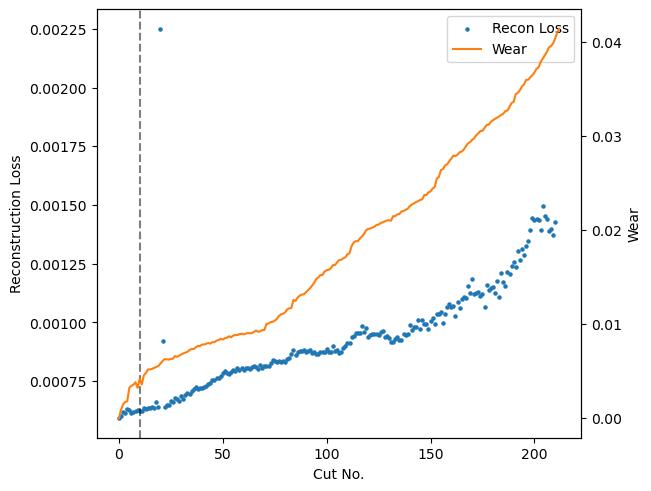

In [80]:
# wear plot
mean_rad = exp_data.features['Mean radius']
wear = np.abs(mean_rad - mean_rad[0])


fig, ax = plt.subplots(constrained_layout=True)
ax.scatter(range(len(recon_scores)),
            recon_scores,
            s=5,
            label='Recon Loss',
            )
ax.axvline(TRAIN_STOP,
            color='k',
            linestyle='--',
            alpha=0.5,
            )
ax2 = ax.twinx()
ax2.plot(wear, 'C1', label='Wear')

ax.set_ylabel('Reconstruction Loss')
ax2.set_ylabel('Wear')
ax.set_xlabel('Cut No.')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# fig.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(1, 1))
ax.legend(lines + lines2, labels + labels2, loc='best')
plt.show()

7/7 [==============================] - 0s 3ms/step


ValueError: x and y must be the same size

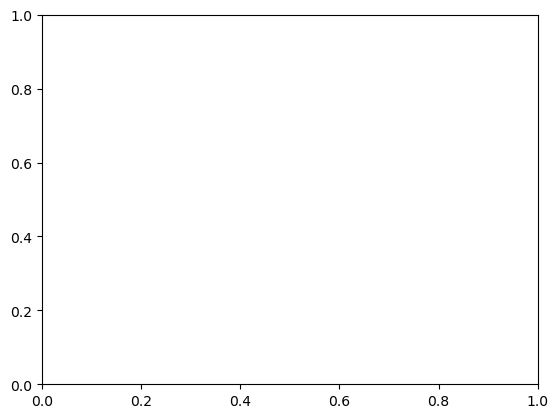

In [81]:
encoder = autoe.get_layer('encoder')
en_data = encoder.predict(data_sc)
plt.scatter(range(len(en_data)), en_data, s=5)